<img src="media/Cryo+ESA_Logo_plain-50gray.svg" alt="CCI Cryosphere banner" width="1000"/>

# Exercise: Cryosat-2 Sea ice thickness maps
On the open data portal you can find [sea ice thickness products derived from Cryosat-2](https://climate.esa.int/en/odp/#/project/sea-ice). This exercise will show you how to visualize and process these.

## Preparations
If you haven't done so please follow the [Cate tutorial](https://www.futurelearn.com/courses/understanding-climate-change-using-satellite-climate-data/1/steps/1230976) to get started using the Jupyter notebook exercises.

## Cate software and the open data portal

We'll be querying the open data portal for sea ice concentration products as produced by the [Climate Change Initiative Sea Ice project](https://climate.esa.int/en/projects/sea-ice/). The [**open data portal**](https://climate.esa.int/en/odp/#/dashboard) hosts a variety of datasets on the [Jasmin infrastructure on the UK](https://jasmin.ac.uk/). These can be queried using the dedicated [Cate python module](https://cate.readthedocs.io/en/latest/). Cate allows retrieving data from the data portal and the web-interface which you find at [cate.climate.esa.int](https://cate.climate.esa.int) is build upon it.

In this Jupyter notebook exercise we will directly call Cate functions, and it will show you how these can be used in advanced workflows.

## Starting the exercise
To perform the exercise and execute the code in this notebook you can run it through the [mybinder.org](https://mybinder.org/) service by clicking on the binder link below (if resources allow it). Alternatively, you can download/clone the notebooks from [github](https://github.com/CCI-Tools/cate-edu) and run them through your own Jupyter notebook instance (this may initially take more time to setup, but does allow you to store your changes and extend the notebooks exercises to your own needs).

[![click to run this notebook on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CCI-Tools/cate-edu/HEAD?filepath=ECVs%2F05_CCISeaIceThickness-exercise.ipynb)

or [clone the notebook repository on github](https://github.com/CCI-Tools/cate-edu)

## Step 1: loading python modules and initialize the data store pool

In [1]:
# To get things started we need to initialize a few things
#Load some python modules to make them accessible to the notebook
from cate.core.ds import DATA_STORE_POOL
import cate.ops as ops
from cate.ops.io import open_dataset

# the following is needed to run Cate in a Jupyter Notebook
from xcube.util.ipython import enable_asyncio
enable_asyncio()

# utilities
from IPython.display import display
import numpy as np
from datetime import datetime

To begin, let us see which data stores are available in the Data Store Pool.

In [2]:
DATA_STORE_POOL.store_instance_ids

['cci-store', 'cci-zarr-store', 'local']

We see three different stores. 

The **cci-store** is a store that provides access to all datasets from the CCI Open Data Portal. It connects to the Open Data Portal and allows access to the datasets listed at https://catalogue.ceda.ac.uk. We can ask for the search parameters of the store to see how a search can be performed.

The **cci-zarr-store** is a store that contains selected data from the Open Data Portal, converted to the [zarr format](https://zarr.readthedocs.io/en/stable/). The datasets from this store can be opened and processed faster, but the store provides only a small subset of what is offered by the **cci-store**. 

The **local** data store finally allows to access locally provided data. Also, when you select to cache data, you will find it in this store. Cached data can also be opened quickly.

This notebook will allow you to try out both the *cci-zarr-store* and the *cci-store*. Just uncomment/comment the appropriate `cci_store` variable below.

In [3]:
# uncomment/comment the cci_store variable below to use the 
# cci_store = 'cci-zarr-store'
cci_store = 'cci-store'

data_store = DATA_STORE_POOL.get_store(cci_store)
display(data_store.get_search_params_schema())

if cci_store == 'cci-zarr-store':
    #you can also list all the data ids of the smaller zarr catalogue
    list(data_store.get_data_ids())

## Step 2: Finding sea ice thickness data
For this exercise, we are interested in Sea Ice data sets, so we ask for datasets of the ecv "SEAICE". Also, to further restrict our search, we look for the data type 'SITHICK', as we are interested in Sea Ice Thickness. We then display the results of the query.

In [4]:
# To get an idea of what is available in the online data portal one can query it and loop over it's result to print some information to the screen
#the query siconc is short for sea ice concentration
seaiceqry = [d for d in data_store.search_data(ecv='SEAICE') if d.attrs.get("data_type")=="SITHICK"]

for i,seaiceItem in enumerate(seaiceqry):
    print(f'\nDataset item {i}:')
    display(seaiceItem)


Dataset item 0:



Dataset item 1:



Dataset item 2:



Dataset item 3:



Dataset item 4:



Dataset item 5:



Dataset item 6:



Dataset item 7:


There are several sea ice thickness products from Cryosat-2 available. You can choose between along track (Swath) datasets or gridded variants, and products for both the Northern and Southern hemisphere are available. Let's have a look at the gridded sea ice thickness product in the Northern hemisphere.

In [5]:
#note the appropriate dataset is called slightly different depending on the cci-store which is being used
if cci_store == 'cci-store':
    dataset_id = "esacci.SEAICE.mon.L3C.SITHICK.SIRAL.CryoSat-2.NH25KMEASE2.2-0.r1"
elif cci_store == "cci-zarr-store":
    dataset_id = "ESACCI-SEAICE-L3C-SITHICK-SIRAL_CRYOSAT2-NH25KMEASE2-2010-2017-fv2.0.zarr"


In [6]:
#Select the Northern Hemisphere gridded dataset

# Open the dataset for use (this may take a while so we only take one year at this stage)
seaice_th_ds = open_dataset(ds_id=dataset_id, data_store_id=cci_store, normalize=True)

/home/alicja/miniconda3/envs/cate-env/lib/python3.9/site-packages/xcube_cci/dataaccess.py:286: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(chunk_store)


## Step 3: Find out how  Freeboard and (approximate) sea ice thickness relate to each other

To first order, one can apply the Archimedes principle to convert the freeboard height to the thickness of the sea ice. To do this one could take the variable `freeboard`, which has a correction for the less dense snow on top of the ice corrected for and convert it using the following formula, assuming a uniform ice and sea water density $\rho_{ice}$ and $\rho_{w}$ respectively.
![Freeboard versus ice thickness](media/cryosatfreeboard.gif)

$h_{seaice}=h_{freeboard}\left(\frac{\rho_{w}}{\rho_{w}-\rho_{ice}}\right)$

So using reasonable values for the densities, we can compute a factor which gives us an idea how the freeboard height relates to the sea ice thickness. It turns out that only about 1/8th of the actual sea ice thickness is visible above the waterline as freeboard:

In [7]:
rho_ice = 900 # ice density kg/m^3
rho_w = 1027 # sea water density kg/m^3

freeb2seaice = rho_w/(rho_w - rho_ice)
print (f"Approximate freeboard to sea ice thickness conversion factor {freeb2seaice}")

Approximate freeboard to sea ice thickness conversion factor 8.086614173228346


FreeboardThe dataset, which we opened above, has a variable called `sea_ice_thickness` which uses better estimates of the ice and sea water densities, and also incorporates the density of the snow layer which is sitting on top of the sea ice. So we can take that variable and make an animation.

## Step 4: Create an animation of the arctic sea ice thickness

In [8]:
import matplotlib.pyplot as plt
from matplotlib import animation,cm
from IPython.display import HTML
import numpy as np
from copy import copy
# Make sure that the initial iconcentrationmage is not shown inline in the notebook
%matplotlib

# We also want to visualize the chang over time so we create an animation with the python module matplotlib
# You can find more information on matplotlib animations here: https://matplotlib.org/stable/api/animation_api.html

ith = 0
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

cmSea = copy(cm.get_cmap("viridis"))
cmSea.set_bad('grey')

#let's strip off the irrelevant edges which contain Nan's
xrng = np.arange(120, 300)
yrng = np.arange(120, 300)

im = ax.imshow(seaice_th_ds.sea_ice_thickness.isel(time=ith, xc=xrng, yc=yrng).data, cmap=cmSea)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("meter")

nframes = seaice_th_ds.dims["time"]

def initSeaice():
    ax.set_title(f"Sea ice thickness {np.datetime_as_string(seaice_th_ds.time[ith],unit='D')}")    
    return (im,)

def animSeaIce(i):
    print(f"Animating frame {i} of {nframes - 1}", end="\r")
    ax.set_title(f"Sea ice thickness {np.datetime_as_string(seaice_th_ds.time[i],unit='D')}")
    im.set_array(seaice_th_ds.sea_ice_thickness.isel(time=i, xc=xrng, yc=yrng).data)
    return (im,)



anim = animation.FuncAnimation(fig, animSeaIce, 
                               init_func=initSeaice,
                               frames=nframes, 
                               interval=100, 
                               blit=True)

# The to_jshtml call creates some html code and javascript which allows us to control the animation
HTML(anim.to_jshtml())


Using matplotlib backend: TkAgg


## Step 5: Conversion of sea ice thickness and sea ice concentration to sea ice volume

Upon a closer inspection of the dataset, one can also find a sea ice concentration variable, $C_{seaice}$, which has been interpolated on the same grid. This allows us to compute sea ice volume variations, $V_{seaice}$ over time by integrating over the valid data points of the Arctic:

$V_{seaice} (t)=\int_{Arctic} C_{seaice}(\theta,\lambda,t) h_{seaice}(\theta,\lambda,t) \sin \theta d\theta d\lambda$

We have the advantage that the data is already supplied as a Lambert azimuthal equal-area projection, so we can assign the same area, $dA$, to each 25kmx25km grid cell and simply convert the integral to a sum.

$V_{seaice} (t)\approx \sum_{i,j} C_{seaice}(i,j,t) h_{seaice}(i,j,t) dA$

So let's try to compute this discrete integral from our data:

In [9]:
dA = 25**2 # cell area in km^2
#note the conversion factor 1e-5 accounts for converting meter to km and sea ice concentration in percent to a fraction 
conv = 1e-5
tmp = conv * seaice_th_ds.sea_ice_thickness * seaice_th_ds.sea_ice_concentration 
Vseaice = dA * tmp.sum(dim=['xc','yc'],skipna=True)
Vseaice = Vseaice.where(Vseaice != 0) #note we need to remove data where no observations have taken place (in this case these are filled with exact zeros)

Once we have the time series, we can plot the variation over time

Text(0, 0.5, 'km^3')

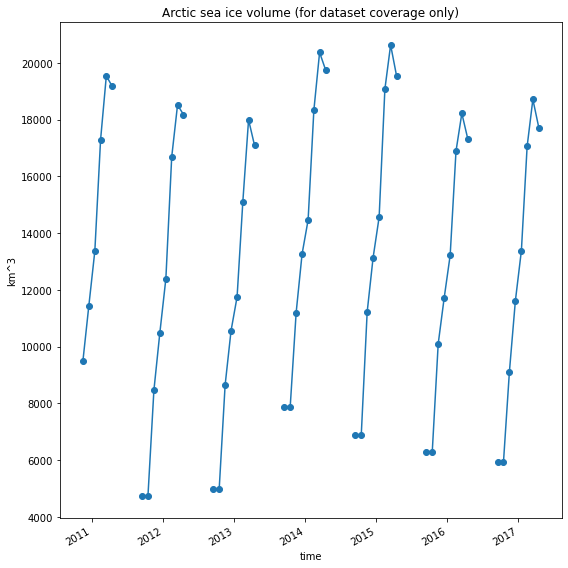

In [10]:
%matplotlib inline 
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
Vseaice.plot(ax=ax, marker='o')
ax.set_title("Arctic sea ice volume (for dataset coverage only)")
ax.set_ylabel("km^3")

# Questions (please share your answers and images and discuss these on the forum)
Now that you've done the exercises, it's time to try to answer the following exercises.

1. Try plotting the variables `freeboard`, `radar_freeboard`. How much do they differ? What is causing the difference?
2. To compare the behavior among the different seasons, try creating a plot which has the months as x-axis. Hint: you can use [xarray's groupby function](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) to sort the dataset.
3. From the animation it looks like the ice is drifting over time. Try to create so called [Hovmöller plots](https://cate.readthedocs.io/en/latest/use_cases.html?highlight=hovm%C3%B6ller#analysis-of-equatorial-aerosol-and-cloud-features-using-hovmoller-diagrams) of certain x,y sections (2D plot with the spatial coordinate on the x axis and the time axis on the y axis colored according to the sea ice thickness). Can you spot the sea ice drift in those plots?